# IMPORTS

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image,ImageColor,ImageDraw,ImageFont,ImageOps

# Capture camera data

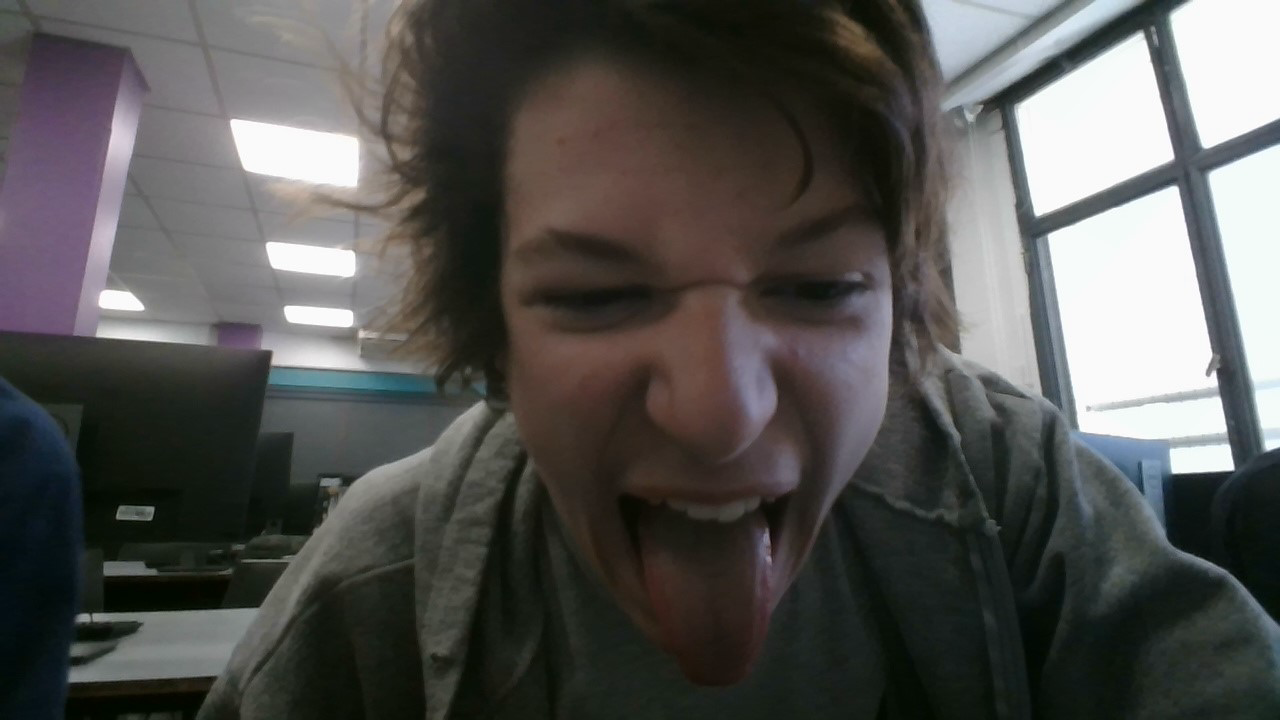

In [ ]:
def captureCamera(cam): # Capturar el frame de la camera
    ret, frame = cam.read() # Obtener el frame de la camara
    return frame

video = cv2.VideoCapture(vid) # Inizializar la camara
img = captureCamera(video)
cv2.imshow(img)

# IA

### Load IA from the hub

In [ ]:
model= "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" # El modelo pre-entrenado
detector = hub.load(model).signatures['default'] # Cargar el modelo

### Boxes draw

In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.5):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

def debugImg(objNames, objScores, objBoxes, minScore=0.9): # Depura las imagenes
  detected = []
  for i in range(len(objNames)):
    if objScores[i] >= minScore: # Si es menor a la MinScore
      detected.append([objNames[i], objBoxes[i]]) # AGREGALO
  return detected # Devolve la lista


### IA test

In [ ]:
def runDetector(detector, img):
    clear_output(wait=True)
    convertedImg  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] # Convertir la imagen a un Float
    startTime = time.time()
    result = detector(convertedImg) # Resultado de la deteccion de la IA
    finishTime = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("----Data----")
    print(f"Objetos encontrados: {len(result)}")
    print(f"Tiempo: {finishTime - startTime}")
    imageWithBoxes = draw_boxes(
      img, result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], min_score=0.25) # Dibujar las cajas en la imagen
    debugImg(result["detection_class_entities"], result["detection_scores"],result["detection_boxes"],minScore=0.25)
    cv2_imshow(imageWithBoxes)

    valid_classes = ["Man", "Person", "Human face", "Human head", "Jeans", "Footwear"]
    print(str(result["detection_scores"][0]))
    print(str(result["detection_class_entities"][0]))
    print(result)
    if str(result["detection_class_entities"][0])[2:-1] in valid_classes:
      if center[0] < im_width//2:
        side = "L"
      else: side = "R"
      
      return True, side
    return False, None


### IA real time test

In [ ]:
src = files.upload()
menem = list(src.keys())[0] 
cv2.imread(menem)

In [ ]:
#while True:
#    runDetector(detector, captureCamera(video))

----Data----
Objetos encontrados: 5
Tiempo: 0.2005603313446045


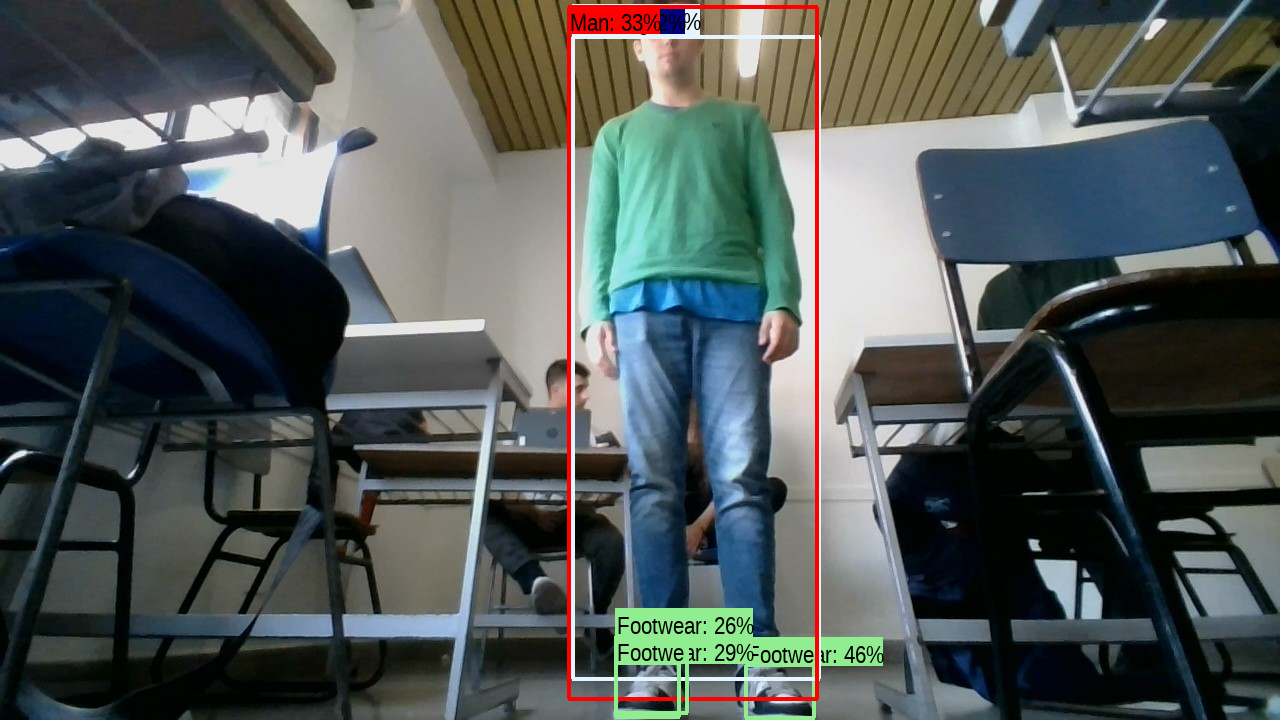

0.4638473
b'Footwear'
{'detection_class_labels': array([434, 433,  69, 308, 434, 434,  97,  97, 502, 434, 434,  97, 434,
        97, 434, 434, 434, 434, 434, 433, 434,  97, 281, 434,  97,  97,
       434, 281, 434, 281,  97, 434,  97,  97,  97, 281,  97, 281,  97,
       281, 434,  97, 434,  97,  97,  97, 434, 434,  97, 433, 281,  97,
        97,  97, 281, 281,  97, 434,  97,  97,  97, 281, 434, 434, 434,
        97,  97, 434,  97, 434,  97, 281,  97, 434,  97,  97, 434,  97,
       281, 433, 434,  97, 281, 434, 433, 281, 281, 434, 434, 485,  97,
       281,  97,  97, 434, 434, 281, 281,  97,  97]), 'detection_scores': array([0.4638473 , 0.42346317, 0.42269966, 0.33845857, 0.29564533,
       0.26816922, 0.22364877, 0.22311643, 0.20612413, 0.17638077,
       0.1707385 , 0.15275335, 0.14988163, 0.14508973, 0.14413472,
       0.13431513, 0.13360931, 0.13252483, 0.13028301, 0.12606168,
       0.12563638, 0.12153333, 0.11129934, 0.10973305, 0.10960312,
       0.10882774, 0.10825741, 0.10795

True

In [ ]:
runDetector(detector, cv2.imread(menem))